In [15]:
import os
os.chdir(r"C:\Users\Negar\Desktop\paper_results\Myself\cr_coad_project")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
from pathlib import Path


In [16]:
# Paths
DATA_DIR   = Path("data/processed/images/rep_slices")
INDEX_PATH = Path("data/processed/images/rep_index.csv")
SPLITS_DIR = Path("data/splits")
RESULTS_DIR = Path("results/images")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)


In [17]:
# Reload the model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import Sequential, layers

IMG_SIZE = (224,224)

base = EfficientNetB0(include_top=False, input_shape=IMG_SIZE+(3,),
                      weights="imagenet", pooling="avg")
base.trainable = False

model = Sequential([
    base,
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")
])

# Load trained weights
model.load_weights("results/images/baseline_image_weights_only.h5")
print("✅ Model reloaded successfully.")


✅ Model reloaded successfully.


In [18]:
# Build test dataset
# Load split and index
df = pd.read_csv(INDEX_PATH)
test_ids = pd.read_csv(SPLITS_DIR / "test_series.csv")["series_id"].tolist()
df = df[df.series_id.isin(test_ids)]

print("Test samples:", len(df))

def decode_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img

paths  = df["rep_slice"].astype(str).tolist()
labels = (np.arange(len(df)) % 2).astype(int)   # same fake labels as before

test_ds = tf.data.Dataset.from_tensor_slices((paths, labels))
test_ds = test_ds.map(lambda p,y: (decode_img(p), y)).batch(8)


Test samples: 5


In [19]:
# Evaluate and plot metrics
y_true = np.array(labels)
y_pred = (model.predict(test_ds) > 0.5).astype(int).ravel()
y_prob = model.predict(test_ds).ravel()

# Metrics
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, output_dict=True)

# ROC
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)
print("ROC-AUC:", roc_auc)

# Save metrics
pd.DataFrame(report).to_csv(RESULTS_DIR/"eval_metrics.csv")


1/1 [==============================] - 0s 275ms/step
ROC-AUC: 0.8333333333333334


c:\Users\Negar\anaconda3\envs\crlm\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Negar\anaconda3\envs\crlm\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Negar\anaconda3\envs\crlm\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0]

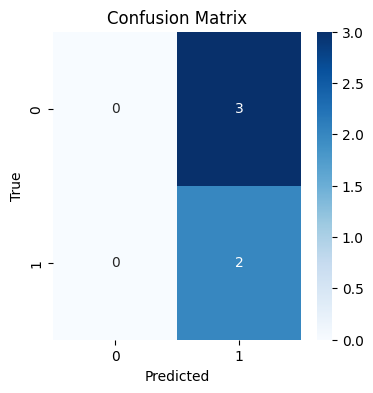

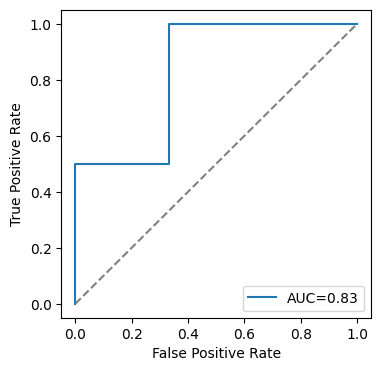

In [20]:
# Confusion matrix
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig(RESULTS_DIR/"confusion_matrix.png", dpi=200)
plt.show()

# ROC curve
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.2f}")
plt.plot([0,1],[0,1],"--",color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.savefig(RESULTS_DIR/"roc_curve.png", dpi=200)
plt.show()


✅ Last conv layer: top_conv
✅ Grad model built successfully (continuous graph).


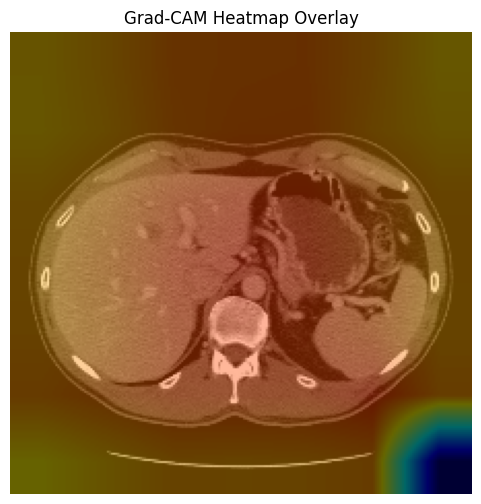

In [22]:
# Grad-CAM with Sequential + EfficientNetB0
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# --- STEP 1: Identify the base model and last conv layer ---
base_model = model.layers[0]  # EfficientNetB0

def get_last_conv_layer(m):
    for layer in reversed(m.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer
    raise ValueError("No Conv2D layer found")

last_conv = get_last_conv_layer(base_model)
print("✅ Last conv layer:", last_conv.name)

# --- STEP 2: Rebuild a new 'grad_model' that passes through dropout & dense ---
# Manually chain: base_model.input → last conv output → dropout → dense
x = base_model.output  # output of EfficientNet (after global avg pooling)
for l in model.layers[1:]:   # apply the remaining layers manually
    x = l(x)

grad_model = tf.keras.models.Model(
    inputs=base_model.input,
    outputs=[last_conv.output, x]
)
print("✅ Grad model built successfully (continuous graph).")

# --- STEP 3: Prepare one sample image ---
path = df["rep_slice"].iloc[0]
img = decode_img(path)
img_array = tf.expand_dims(img, axis=0)

# --- STEP 4: Compute Grad-CAM ---
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_array)
    loss = predictions[:, 0]

grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
conv_outputs = conv_outputs[0]
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1).numpy()

# Normalize
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
heatmap = cv2.resize(heatmap, (IMG_SIZE[1], IMG_SIZE[0]))

# --- STEP 5: Overlay Grad-CAM ---
img_np = (img.numpy() * 255).astype(np.uint8)
heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(img_np, 0.6, heatmap_color, 0.4, 0)

plt.figure(figsize=(6,6))
plt.imshow(overlay)
plt.title("Grad-CAM Heatmap Overlay")
plt.axis("off")
plt.show()



In [23]:
print("hi")

hi
